# Imports and Definitions

In [1]:
import os
import glob
import json
import requests

import uproot
import numpy as np
import awkward as ak
import scipy.interpolate
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt

import thesis.config
import thesis.isotopes
import thesis.constants
import thesis.analysis as ta

In [2]:
use_tex = False
if (use_tex):
    thesis.config.use_tex()
else:
    thesis.config.use_inline()
config_file_path = "/users/wctaylor/wctaylor_thesis_code/config/example_config.json"
thesis.config.config_env(config_file_path)
FIG_DPI=450

In [3]:
def get_endf_cross_section(filepath):
    """
    Get cross section vs energy points from ENDF/B-VII.1 data files
    
    Parameters
    ----------
    filepath: str
        Path to the cross section data file
        
    Returns
    -------
    cross_section_data: dict
        A dict containing the cross section vs energy points from the file
    """
    with open(filepath, "r") as data_file:
        data = data_file.readlines()
    temp     = data[0].split()
    library  = temp[1].strip()
    temp     = temp[0].split("(")
    iso      = temp[0].split("-")
    isotope  = f"$^{{{iso[2]}}}${iso[1]}"
    reaction = f"({temp[1]}"
    if (reaction == "(n,&gamma;)"):
        reaction = "$(n, \gamma)$"
            
    energy_eV       = np.zeros(len(data[1:]))
    cross_section_b = np.zeros(len(data[1:]))
    for i in range(1, len(data)):
        temp = data[i].split(",")    
        energy_eV[i-1]       = float(temp[0])
        cross_section_b[i-1] = float(temp[1])
    
    cross_section_data = \
    {
        "energy_eV": energy_eV,
        "cross_section_b": cross_section_b
    }
    
    return cross_section_data

In [4]:
def get_ngatlas_cross_section(filepath):
    """
    Get cross section vs energy points from NGATLAS data files
    
    Parameters
    ----------
    filepath: str
        Path to the cross section data file
        
    Returns
    -------
    cross_section_data: dict
        A dict containing the cross section vs energy points from the file
    """
    NAME_BEGIN = "#name:"
    DATA_BEGIN = "#data..."
    DATA_END = "//"
    
    with open(filepath, "r") as data_file:
        data = data_file.readlines()
    
    data_found = False
    data_start_index = -1
    data_end_index = -1
    for i in range(len(data)):
        if (data[i].startswith(NAME_BEGIN)):
            reaction = data[i].split()[1].split("-")[1]
            if (reaction == "102" or reaction == "402"):
                data_found = True
        if (data_found):
            if (data[i].startswith(DATA_BEGIN)):
                axes = data[i + 1]
                units = data[i + 2]
                data_start_index = i + 3
            if (data[i].startswith(DATA_END)):
                data_end_index = i
    energy_eV       = np.zeros(len(data[data_start_index:data_end_index]))
    cross_section_b = np.zeros(len(data[data_start_index:data_end_index]))
    for i in range(data_start_index, data_end_index):
        temp = data[i].split()
        energy_eV[i - data_start_index]       = float(temp[0])
        cross_section_b[i - data_start_index] = float(temp[1])
    
    cross_section_data = \
    {
        "energy_eV": energy_eV*1e6, # data provided in MeV
        "cross_section_b": cross_section_b
    }
    
    return cross_section_data

In [5]:
def get_cross_section_data(library, filepath):
    """
    Get cross section vs energy points for an isotope and reaction
    
    Parameters
    ----------
    library: str
        Which cross section library is being used
    filepath: str
        Path to the cross section data file
        
    Returns
    -------
    cross_section_data: dict
        A dict containing the cross section vs energy points for
        the input reaction and isotope
    """    
    if (library == "ENDF/B-VII.1"):
        data = get_endf_cross_section(filepath)
    elif (library == "NGATLAS"):
        data = get_ngatlas_cross_section(filepath)
    else:
        raise ValueError(f"{library} is not a supported library.")
    
    return data
    

In [6]:
def interpolate_cross_section_data(cross_section_data, kind="linear"):
    """
    Generate additional data points within the provided cross section data
    via interpolation. 
    Useful for averaging
    
    Parameters
    ----------
    cross_section_data: dict
         A dict containing the cross section vs energy points for
    the input reaction and isotope
    """
    energy_eV = cross_section_data["energy_eV"]
    cross_section_b = cross_section_data["cross_section_b"]
    
    values, indices, counts = np.unique(energy_eV, 
                                        return_index=True, 
                                        return_counts=True)
    duplicates = values[counts > 1]
    
    new_E = energy_eV[indices]
    new_xs = cross_section_b[indices]
    for duplicate in duplicates:
        cut_dupe = (energy_eV == duplicate)
        avg_xs = np.sum(cross_section_b[cut_dupe])/len(cross_section_b[cut_dupe])
        new_index = (new_E == duplicate)
        new_xs[new_index] = avg_xs
    interpolation = scipy.interpolate.interp1d(new_E,
                                               new_xs,
                                               kind=kind,
                                               fill_value="extrapolate")
    return interpolation



In [7]:
def get_averaged_cross_section_data(cross_section_data, bin_range=None,
                                    num_bins=100, num_interpolation_bins=1000):
    energy_eV       = cross_section_data["energy_eV"]
    cross_section_b = cross_section_data["cross_section_b"]
    
    if (bin_range is None):
        bin_range = [np.min(energy_eV), np.max(energy_eV)]
    bins  = np.logspace(np.log10(bin_range[0]), 
                        np.log10(bin_range[1]), 
                        num_bins)
    interpolation_bins = np.logspace(np.log10(bin_range[0]),
                                     np.log10(bin_range[1]),
                                     num_interpolation_bins)
    interpolation = interpolate_cross_section_data(cross_section_data)
    interpolated_cross_sections = interpolation(interpolation_bins)

    data = np.zeros_like(bins)
    for index in range(len(bins)):
        if (index == (len(bins)-1)):
            cut_energy = (interpolation_bins >= bins[index])
        else:
            cut_energy = (  (interpolation_bins >= bins[index]) 
                          * (interpolation_bins < bins[index+1])  )

        energies = interpolation_bins[cut_energy]
        if (len(energies) > 0):
            cross_sections = interpolated_cross_sections[cut_energy]
            avg = np.sum(cross_sections)/len(cross_sections)
            data[index] = avg
        else:
            continue

    avg_data = \
    {
        "energy_eV": bins,
        "cross_section_b": data
    }

    return avg_data

In [8]:
def plot_cross_section_data(cross_section_data, 
                            xlim=None, ylim=None, filename=None):
    isotope         = cross_section_data["isotope"]
    reaction        = cross_section_data["reaction"]
    library         = cross_section_data["library"]
    energy_eV       = cross_section_data["energy_eV"]
    cross_section_b = cross_section_data["cross_section_b"]
    
    fig, axes = plt.subplots()
    plt.plot(energy_eV, cross_section_b)
    axes.set_xlabel("Energy [eV]")
    axes.set_xscale("log")
    if (xlim is not None):
        axes.set_xlim(xlim)
    axes.set_ylabel("Cross Section [b]")
    axes.set_yscale("log")
    if (ylim is not None):
        axes.set_ylim(ylim)
    axes.set_title(f"{isotope} {reaction} Cross Section\n"
                   f"Library: {library}")
    
    if (filename is not None):
        plt.savefig(filename, dpi=FIG_DPI)
    
    plt.show()

In [9]:
def get_XeBox_size_mm(header):
    dim = None
    unit = None
    
    commands = ak.to_list(header["sInputCommands"].array())
    commands = commands[0].split("\n")
    
    xebox_selected = False
    for command in commands:
        if (command == "/Bacc/detector/select XeBox"):
            xebox_selected = True
        if (command.startswith("/XeBox/setBoxSize")):
            dim  = command.split()[1]
            unit = command.split()[2]
    if not (xebox_selected):
        raise ValueError("Can't obtain XeBox size "
                         "from non-XeBox geometry simulation.")
    # XeBox geometry has a default size of 1 m
    if ((dim is None) and (unit is None)):
        dim = 1
        unit = "m"
    else:
        dim = float(dim)
        if   (unit == "m"):
            return dim*1000
        elif (unit == "dm"):
            return dim*100
        elif (unit == "cm"):
            return dim*10
        elif (unit == "mm"):
            return dim
        elif (unit == "um"):
            return dim/1000
        elif (unit == "nm"):
            return dim/1000000
        else:
            raise ValueError("Unsupported units in macro")

In [10]:
def get_decay_spectrum(filepath, fields, aliases, metastable=False):
    with uproot.open(filepath) as root_file:
        header = root_file["HeaderTree"]
        events = root_file["DataTree"]
        arrays = events.arrays(fields, aliases=aliases)
        cut_track_electron  = (arrays["track_particle_ids"] == ELECTRON_ID)
        cut_track_gamma     = (arrays["track_particle_ids"] == GAMMA_ID)
        cut_track_decay     = (arrays["track_processes"] == "RadioactiveDecay")
        cut_track_primary   = (arrays["track_processes"] == "primary")
        
        cut_step_electron   = ta.track_to_step(cut_track_electron, 
                                               arrays["step_track_indices"])
        cut_step_gamma      = ta.track_to_step(cut_track_gamma, arrays["step_track_indices"])
        cut_step_creation   = (arrays["step_processes"] == "Creation")
        cut_step_from_decay = ta.track_to_step(cut_track_decay, 
                                               arrays["step_track_indices"])
        cut_step_primary    = ta.track_to_step(cut_track_primary,
                                               arrays["step_track_indices"])

        # The size is the length, L,  of an edge of the cube,
        # but the coordinates run from -L/2 to +L/2
        xeblock_size_mm     = get_XeBox_size_mm(header)
        cut_step_fiducial   = (  (  np.abs(arrays["step_x_mm"]) 
                                  < 0.9*(xeblock_size_mm/2)  )
                               * (  np.abs(arrays["step_y_mm"]) 
                                  < 0.9*(xeblock_size_mm/2)  )
                               * (  np.abs(arrays["step_z_mm"]) 
                                  < 0.9*(xeblock_size_mm/2)  )  )


        if (metastable):
            cut = (  cut_step_creation
                   * cut_step_primary
                   * cut_step_fiducial)
            num_decays = ak.sum(ak.any(cut_step_primary*cut_step_fiducial, 
                                       axis=1))
        else:
            # Gamma + Electron Creation Energies within a Fiducial Region
            cut = (  cut_step_creation
                   * np.logical_or(cut_step_gamma, cut_step_electron)
                   * cut_step_from_decay 
                   * cut_step_fiducial  )
            num_decays = ak.sum(ak.any(cut_step_creation*cut_step_fiducial, 
                                       axis=1))
        
        E_flat = ak.to_numpy(ak.flatten(ak.sum(arrays["step_energy_keV"][cut], 
                                       axis=1, mask_identity=True), 
                                axis=0))
    return num_decays, E_flat

# Cross Sections

In [9]:
figure_dir = os.environ["FIGURE_DIR"]
NUM_BINS = 70
NUM_INTERPOLATION_BINS=1000*NUM_BINS
LOWER_BOUND_X = 1e-2
UPPER_BOUND_X = 2e7
LOWER_BOUND_Y = 1e-6

for isotope, isotope_data in thesis.isotopes.ISOTOPES.items():
    
    if (len(isotope_data["parents"]) == 0):
        continue
    
    fig, axis = plt.subplots(figsize=(6,6))

    do_plot = False
    lower_bound_y = None
    
    for pair in isotope_data["parents"]:
        for parent, process in pair.items():
            production_data = thesis.isotopes.ISOTOPES[parent]["processes"][process]
            production_data = production_data["children"][isotope]
            if ("cross_sections" in production_data):
                for library, filename in production_data["cross_sections"].items():                    
                    if (filename is None):
                        continue
                    else:
                        if (library == "ENDF/B-VII.1"):
                            lib = "endf"
                        if (library == "NGATLAS"):
                            lib = "ngatlas"
                        data_path = f'{os.environ["CROSS_SECTION_DATA_DIR"]}/{lib}'
                        filepath = f"{data_path}/{filename}"
                        cross_section_data = get_cross_section_data(library, filepath)

                        do_plot = True
                        cut = (cross_section_data["cross_section_b"] != 0)
                        if (np.min(cross_section_data["cross_section_b"][cut]) < LOWER_BOUND_Y):
                            lower_bound_y = LOWER_BOUND_Y
                        avg_data = get_averaged_cross_section_data(cross_section_data,
                                                                   bin_range=(LOWER_BOUND_X, 
                                                                              UPPER_BOUND_X), 
                                                                   num_bins=NUM_BINS,
                                                                   num_interpolation_bins=NUM_INTERPOLATION_BINS)
                        cut = (avg_data["cross_section_b"] != 0)
                        if (np.min(avg_data["cross_section_b"][cut]) < LOWER_BOUND_Y):
                            lower_bound_y = LOWER_BOUND_Y
                        if (process == "nCapture"):
                            reaction = "$(n, \gamma)$"
                            parent_label = thesis.isotopes.ISOTOPES[parent]["label"]
                            isotope_label = thesis.isotopes.ISOTOPES[isotope]["label"]
                        elif (process == "neutronInelastic"):
                            reaction = "$(n, n')$"
                            parent_label = thesis.isotopes.ISOTOPES[parent]["label"]
                            isotope_label = parent_label
                        label = f"{parent_label}{reaction}{isotope_label}  {library}"
                        axis.plot(cross_section_data["energy_eV"], 
                                  cross_section_data["cross_section_b"],
                                  label=label)
                        axis.step(avg_data["energy_eV"], 
                                 avg_data["cross_section_b"], 
                                 where="post",
                                 linestyle="--",
                                 label=f"Averaged {label}")
    if (do_plot):
        axis.set_xlabel("Energy [eV]")
        axis.set_ylabel("Cross Section [b]")
        axis.set_xscale("log")
        axis.set_yscale("log")
        axis.set_xlim([LOWER_BOUND_X, UPPER_BOUND_X])
        axis.set_ylim(bottom=lower_bound_y)
        axis.legend(loc='lower left')
        axis.set_title(f"{isotope_data['label']} Production Cross Sections")
        axis.xaxis.set_major_locator(matplotlib.ticker.LogLocator(numticks=9))
        axis.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(subs='all', numticks=90))
        axis.yaxis.set_major_locator(matplotlib.ticker.LogLocator(numticks=9))
        axis.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(subs='all', numticks=90))
        
        if (use_tex):
            fig.savefig(f"{figure_dir}/activation/cross_sections/{isotope}_production.pdf",
                        dpi=FIG_DPI)
        else:
            plt.show()

    else:
        plt.close(fig)

# Energy Spectra

In [11]:
data_dir = "/users/wctaylor/data/baccarat/wctaylor-5.2.7/decays/processed"
figure_dir = os.environ["FIGURE_DIR"]
spectrum_dir = os.environ["SPECTRUM_DATA_DIR"]
do_save = True

ELECTRON_ID = 11
GAMMA_ID = 22

aliases = \
{
    "event_numbers"     : "iEventNumber",
    "track_particle_ids": "tracks_iParticleID",
    "track_processes"   : "tracks_sCreatorProcess",
    "step_processes"    : "tracks_steps_sProcess",
    "step_energy_keV"   : "tracks_steps_dParticleEnergy_keV",
    "step_track_indices": "tracks_steps_iTrackArrayIndex",
    "step_x_mm"         : "tracks_steps_dPosition_mm_x",
    "step_y_mm"         : "tracks_steps_dPosition_mm_y",
    "step_z_mm"         : "tracks_steps_dPosition_mm_z",
}

fields = \
[
    "event_numbers",
    "track_particle_ids",
    "track_processes",
    "step_processes",
    "step_energy_keV",
    "step_track_indices",
    "step_x_mm",
    "step_y_mm",
    "step_z_mm"
]

## Xe125

In [12]:
isotope = "Xe125"
CHANNELS = \
{
    "I[243 keV] + K-shell": 243.382 + 33.1694,
    "I[243 keV] + L-shell": 243.382 + 5.1881,
    "I[243 keV] + M-shell": 243.382 + 1.0721,
    "I[188 keV] + K-shell": 188.416 + 33.1694,
    "I[188 keV] + L-shell": 188.416 + 5.1881,
    "I[188 keV] + M-shell": 188.416 + 1.0721,
    "I[454 keV] + K-shell": 453.792 + 33.1694,
    "I[454 keV] + L-shell": 453.792 + 5.1881,
    "I[454 keV] + M-shell": 453.792 + 1.0721,
    "I[372 keV] + K-shell": 372.066 + 33.1694,
    "I[372 keV] + L-shell": 372.066 + 5.1881,
    "I[372 keV] + M-shell": 372.066 + 1.0721
}

In [13]:
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["I125"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = get_decay_spectrum(filepath, fields, aliases)

I[243 keV] + K-shell 0.5604592258135566
I[243 keV] + L-shell 0.05308077749022631
I[243 keV] + M-shell 0.020621111172292275
I[188 keV] + K-shell 0.21507626232035681
I[188 keV] + L-shell 0.019409724134133582
I[188 keV] + M-shell 0.007929078795220527
I[454 keV] + K-shell 0.040636528825505204
I[454 keV] + L-shell 0.0035240350200980122
I[454 keV] + M-shell 0.0014591707505093332
I[372 keV] + K-shell 0.0003028467595396729


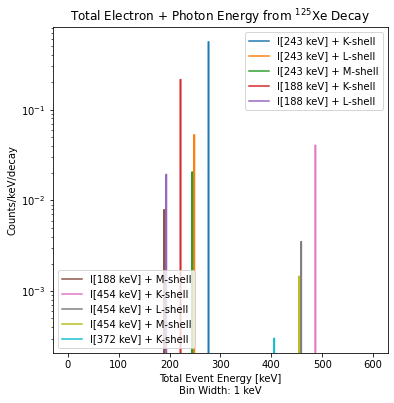

In [17]:
bins = np.arange(0, 600, 1)
bin_width = bins[1] - bins[0]

handles = []
fig, axes = plt.subplots(figsize=(6,6))
for channel, energy in CHANNELS.items():
    cut_channel_E = (E_flat > (energy - bin_width/2)) * (E_flat < (energy + bin_width/2))
    if (np.any(cut_channel_E)):
        print(channel, len(E_flat[cut_channel_E])/len(E_flat))
        centers, counts, errors = thesis.analysis.hist(E_flat[cut_channel_E], 
                                                       bins=bins, 
                                                       scale_factor=1/num_decays)
        if (do_save):
            save_channel = channel.replace(" ", "_")
            with open(f"{data_dir}/xe125_{save_channel}.npz", "wb") as npz_file:
                np.savez(npz_file, 
                         energy_keV=centers, 
                         counts_per_keV_per_decay=counts,
                         errors=errors)
            
    else:
        continue

    plot, = axes.step(centers, counts, where="mid", label=channel)
    handles.append(plot)
axes.set_yscale("log")
axes.set_xlabel(f"Total Event Energy [keV]\n"
                f"Bin Width: {bin_width:.0f} keV")
axes.set_ylabel("Counts/keV/decay")
label = thesis.isotopes.ISOTOPES[isotope]["label"]
axes.set_title(f"Total Electron + Photon Energy from {label} Decay")
legend1 = axes.legend(handles=[handles[i] for i in range(0, len(handles)//2)],
                      loc="upper right")
plt.gca().add_artist(legend1)
legend2 = axes.legend(handles=[handles[i] for i in range(len(handles)//2, len(handles))],
                      loc="lower left")

if (use_tex):
    fig.savefig(f"{figure_dir}/activation/energy_spectra/{isotope}_spectrum.pdf",
                dpi=FIG_DPI)
else:
    plt.show()

## I125

In [18]:
isotope = "I125"
CHANNELS = \
{
    "Te[35 keV] + K-shell": 35.4925 + 31.8138,
    "Te[35 keV] + L-shell": 35.4925 + 4.9392,
    "Te[35 keV] + M-shell": 35.4925 + 1.0060,
}

In [19]:
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Te125"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = get_decay_spectrum(filepath, fields, aliases)

Te[35 keV] + K-shell 0.8033900161559736
Te[35 keV] + L-shell 0.1020016977463786
Te[35 keV] + M-shell 0.04173170130616939


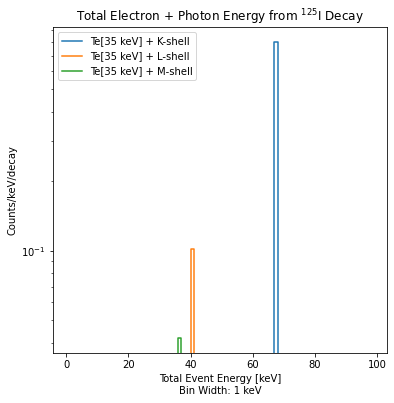

In [20]:
bins = np.arange(0, 100, 1)
bin_width = bins[1] - bins[0]

handles = []
fig, axes = plt.subplots(figsize=(6,6))
for channel, energy in CHANNELS.items():
    cut_channel_E = (E_flat > (energy - bin_width/2)) * (E_flat < (energy + bin_width/2))
    if (np.any(cut_channel_E)):
        print(channel, len(E_flat[cut_channel_E])/len(E_flat))
        centers, counts, errors = thesis.analysis.hist(E_flat[cut_channel_E], 
                                                       bins=bins, 
                                                       scale_factor=1/num_decays)
        if (do_save):
            save_channel = channel.replace(" ", "_")
            with open(f"{data_dir}/i125_{save_channel}.npz", "wb") as npz_file:
                np.savez(npz_file, 
                         energy_keV=centers, 
                         counts_per_keV_per_decay=counts,
                         errors=errors)
    else:
        continue

    plot, = axes.step(centers, counts, where="mid", label=channel)
    handles.append(plot)
axes.set_yscale("log")
axes.set_xlabel(f"Total Event Energy [keV]\n"
                f"Bin Width: {bin_width:.0f} keV")
axes.set_ylabel("Counts/keV/decay")
label = thesis.isotopes.ISOTOPES[isotope]["label"]
axes.set_title(f"Total Electron + Photon Energy from {label} Decay")
axes.legend()
if (use_tex):
    fig.savefig(f"{figure_dir}/activation/energy_spectra/{isotope}_spectrum.pdf",
                dpi=FIG_DPI)
else:
    plt.show()


## Xe127

In [26]:
isotope = "Xe127"
CHANNELS = \
{
    "I[203 keV] + K-shell": 202.860 + 33.1694,
    "I[203 keV] + L-shell": 202.860 + 5.1881,
    "I[203 keV] + M-shell": 202.860 + 1.0721,
    "I[375 keV] + K-shell": 374.992 + 33.1694,
    "I[375 keV] + L-shell": 374.992 + 5.1881,
    "I[375 keV] + M-shell": 374.992 + 1.0721,
#     "I[618 keV] + K-shell": 618.4 + 33.1694,
#     "I[618 keV] + L-shell": 618.4 + 5.1881,
#     "I[618 keV] + M-shell": 618.4 + 1.0721
}

In [29]:
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["I127"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = get_decay_spectrum(filepath, fields, aliases)

I[203 keV] + K-shell 0.44351314957816923
I[203 keV] + L-shell 0.04333727225260381
I[203 keV] + M-shell 0.01808238753469455
I[375 keV] + K-shell 0.3922064360108824
I[375 keV] + L-shell 0.04078155486548133
I[375 keV] + M-shell 0.0176976558850202


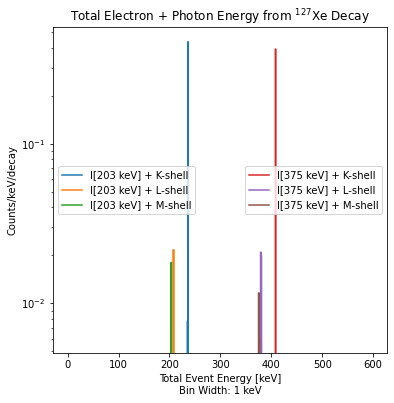

In [30]:
bins = np.arange(0, 600, 1)
bin_width = bins[1] - bins[0]

handles = []
fig, axes = plt.subplots(figsize=(6,6))
for channel, energy in CHANNELS.items():
    cut_channel_E = (E_flat > (energy - bin_width/2)) * (E_flat < (energy + bin_width/2))
    if (np.any(cut_channel_E)):
        print(channel, len(E_flat[cut_channel_E])/len(E_flat))
        centers, counts, errors = thesis.analysis.hist(E_flat[cut_channel_E], 
                                                       bins=bins, 
                                                       scale_factor=1/num_decays)
    
        if (do_save):
                save_channel = channel.replace(" ", "_")
                with open(f"{data_dir}/xe127_{save_channel}.npz", "wb") as npz_file:
                    np.savez(npz_file, 
                             energy_keV=centers, 
                             counts_per_keV_per_decay=counts,
                             errors=errors)
    else:
        continue

    plot, = axes.step(centers, counts, where="mid", label=channel)
    handles.append(plot)
axes.set_yscale("log")
axes.set_xlabel(f"Total Event Energy [keV]\n"
                f"Bin Width: {bin_width:.0f} keV")
axes.set_ylabel("Counts/keV/decay")
label = thesis.isotopes.ISOTOPES[isotope]["label"]
axes.set_title(f"Total Electron + Photon Energy from {label} Decay")
legend1 = axes.legend(handles=[handles[i] for i in range(0, len(handles)//2)],
                      loc="center left")
plt.gca().add_artist(legend1)
legend2 = axes.legend(handles=[handles[i] for i in range(len(handles)//2, len(handles))],
                      loc="center right")

if (use_tex):
    fig.savefig(f"{figure_dir}/activation/energy_spectra/{isotope}_spectrum.pdf",
                dpi=FIG_DPI)
else:
    plt.show()

## Xe129m

In [25]:
isotope = "Xe129m"
CHANNELS = \
{
    "Xe[236]": 236.14,
}
spectrum_file = thesis.isotopes.ISOTOPES[isotope]["spectrum"]
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = get_decay_spectrum(filepath, fields, aliases, 
                                        metastable=True)

Xe[236] 1.0


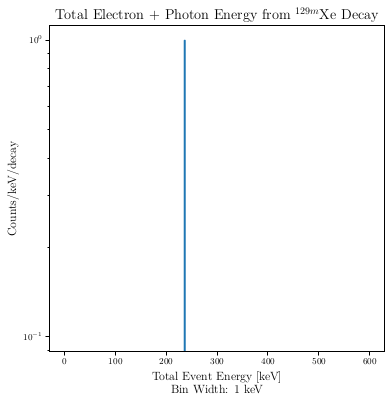

In [28]:
bins = np.arange(0, 600, 1)
bin_width = bins[1] - bins[0]

handles = []
fig, axes = plt.subplots(figsize=(6,6))
for channel, energy in CHANNELS.items():
    cut_channel_E = (E_flat > (energy - bin_width/2)) * (E_flat < (energy + bin_width/2))
    if (np.any(cut_channel_E)):
        print(channel, len(E_flat[cut_channel_E])/len(E_flat))
        centers, counts, errors = myhist(E_flat[cut_channel_E], 
                                         bins=bins, scale_factor=1/num_decays)
    else:
        continue

    plot, = axes.step(centers, counts, where="mid", label=channel)
    handles.append(plot)
axes.set_yscale("log")
axes.set_xlabel(f"Total Event Energy [keV]\n"
                f"Bin Width: {bin_width:.0f} keV")
axes.set_ylabel("Counts/keV/decay")
label = thesis.isotopes.ISOTOPES[isotope]["label"]
axes.set_title(f"Total Electron + Photon Energy from {label} Decay")
# legend1 = axes.legend(handles=[handles[i] for i in range(0, len(handles)//2)],
#                       loc="center left")
# plt.gca().add_artist(legend1)
# legend2 = axes.legend(handles=[handles[i] for i in range(len(handles)//2, len(handles))],
#                       loc="center right")
fig.savefig(f"{figure_dir}/chapter4/energy_spectra/{isotope}_spectrum.pdf",
                    dpi=FIG_DPI)
plt.show()

## Xe131m

In [22]:
isotope = "Xe131m"
CHANNELS = \
{
    "Xe[164]": 163.93,
}
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Xe131"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = get_decay_spectrum(filepath, fields, aliases, 
                                        metastable=True)

In [25]:
bins = np.arange(0, 600, 1)
bin_width = bins[1] - bins[0]

handles = []
fig, axes = plt.subplots(figsize=(6,6))
for channel, energy in CHANNELS.items():
    cut_channel_E = (E_flat > (energy - bin_width/2)) * (E_flat < (energy + bin_width/2))
    if (np.any(cut_channel_E)):
        print(channel, len(E_flat[cut_channel_E])/len(E_flat))
        centers, counts, errors = ta.hist(E_flat[cut_channel_E], 
                                         bins=bins, scale_factor=1/num_decays)
    else:
        continue

    plot, = axes.step(centers, counts, where="mid", label=channel)
    handles.append(plot)
axes.set_yscale("log")
axes.set_xlabel(f"Total Event Energy [keV]\n"
                f"Bin Width: {bin_width:.0f} keV")
axes.set_ylabel("Counts/keV/decay")
label = thesis.isotopes.ISOTOPES[isotope]["label"]
axes.set_title(f"Total Electron + Photon Energy from {label} Decay")
# legend1 = axes.legend(handles=[handles[i] for i in range(0, len(handles)//2)],
#                       loc="center left")
# plt.gca().add_artist(legend1)
# legend2 = axes.legend(handles=[handles[i] for i in range(len(handles)//2, len(handles))],
#                       loc="center right")
fig.savefig(f"{figure_dir}/activation/energy_spectra/{isotope}_spectrum.pdf",
                    dpi=FIG_DPI)
plt.show()

Xe[164] 1.0


## Xe133

In [31]:
isotope = "Xe133"
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Cs133"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = get_decay_spectrum(filepath, fields, aliases, 
                                        metastable=False)

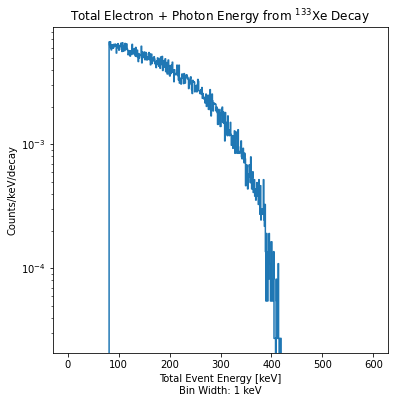

In [32]:
bins = np.arange(0, 600, 1)
bin_width = bins[1] - bins[0]

handles = []
fig, axes = plt.subplots(figsize=(6,6))
centers, counts, errors = ta.hist(E_flat, bins=bins, scale_factor=1/num_decays)

if (do_save):
    with open(f"{data_dir}/xe133.npz", "wb") as npz_file:
        np.savez(npz_file, 
                 energy_keV=centers, 
                 counts_per_keV_per_decay=counts,
                 errors=errors)

plot, = axes.step(centers, counts, where="mid")
handles.append(plot)
axes.set_yscale("log")
axes.set_xlabel(f"Total Event Energy [keV]\n"
                f"Bin Width: {bin_width:.0f} keV")
axes.set_ylabel("Counts/keV/decay")
label = thesis.isotopes.ISOTOPES[isotope]["label"]
axes.set_title(f"Total Electron + Photon Energy from {label} Decay")

if (use_tex):
    fig.savefig(f"{figure_dir}/activation/energy_spectra/{isotope}_spectrum.pdf",
                dpi=FIG_DPI)
else:
    plt.show()

## Xe135

In [33]:
isotope = "Xe135"
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Cs135"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = get_decay_spectrum(filepath, fields, aliases, 
                                        metastable=False)

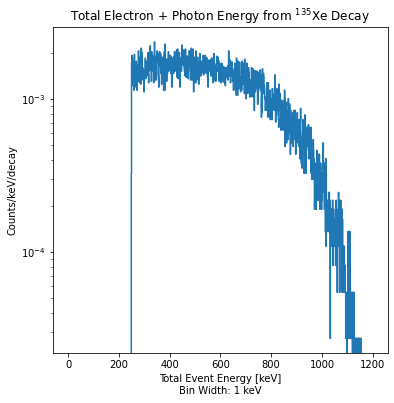

In [34]:
bins = np.arange(0, 1200, 1)
bin_width = bins[1] - bins[0]

handles = []
fig, axes = plt.subplots(figsize=(6,6))
centers, counts, errors = ta.hist(E_flat, bins=bins, scale_factor=1/num_decays)

if (do_save):
    with open(f"{data_dir}/xe135.npz", "wb") as npz_file:
        np.savez(npz_file, 
                 energy_keV=centers, 
                 counts_per_keV_per_decay=counts,
                 errors=errors)

plot, = axes.step(centers, counts, where="mid")
handles.append(plot)
axes.set_yscale("log")
axes.set_xlabel(f"Total Event Energy [keV]\n"
                f"Bin Width: {bin_width:.0f} keV")
axes.set_ylabel("Counts/keV/decay")
label = thesis.isotopes.ISOTOPES[isotope]["label"]
axes.set_title(f"Total Electron + Photon Energy from {label} Decay")

if (use_tex):
    fig.savefig(f"{figure_dir}/activation/energy_spectra/{isotope}_spectrum.pdf",
                dpi=FIG_DPI)
else:
    plt.show()

## Cs135

In [35]:
isotope = "Cs135"
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Ba135"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = get_decay_spectrum(filepath, fields, aliases, 
                                        metastable=False)

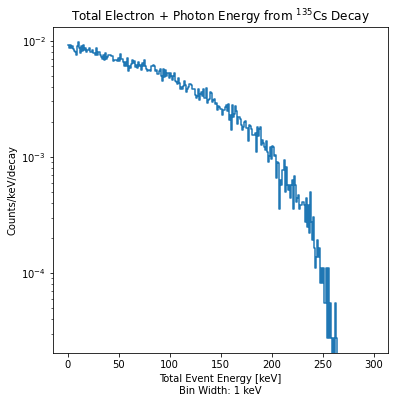

In [36]:
bins = np.arange(0, 300, 1)
bin_width = bins[1] - bins[0]

handles = []
fig, axes = plt.subplots(figsize=(6,6))
centers, counts, errors = ta.hist(E_flat, bins=bins, scale_factor=1/num_decays)

if (do_save):
    with open(f"{data_dir}/cs135.npz", "wb") as npz_file:
        np.savez(npz_file, 
                 energy_keV=centers, 
                 counts_per_keV_per_decay=counts,
                 errors=errors)

plot, = axes.step(centers, counts, where="mid")
handles.append(plot)
axes.set_yscale("log")
axes.set_xlabel(f"Total Event Energy [keV]\n"
                f"Bin Width: {bin_width:.0f} keV")
axes.set_ylabel("Counts/keV/decay")
label = thesis.isotopes.ISOTOPES[isotope]["label"]
axes.set_title(f"Total Electron + Photon Energy from {label} Decay")

if (use_tex):
    fig.savefig(f"{figure_dir}/activation/energy_spectra/{isotope}_spectrum.pdf",
                dpi=FIG_DPI)
else:
    plt.show()

## Xe137

In [37]:
isotope = "Xe137"
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Cs137"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = get_decay_spectrum(filepath, fields, aliases, 
                                        metastable=False)

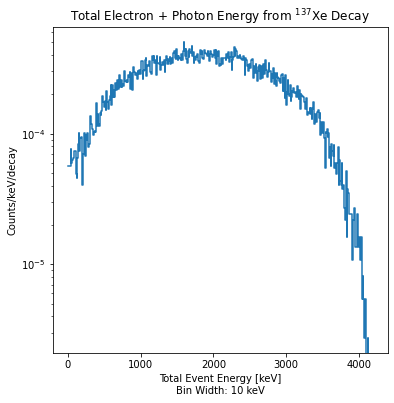

In [38]:
bins = np.arange(0, 4200, 10)
bin_width = bins[1] - bins[0]

handles = []
fig, axes = plt.subplots(figsize=(6,6))
centers, counts, errors = ta.hist(E_flat, bins=bins, scale_factor=1/num_decays)

if (do_save):
    with open(f"{data_dir}/xe137.npz", "wb") as npz_file:
        np.savez(npz_file, 
                 energy_keV=centers, 
                 counts_per_keV_per_decay=counts,
                 errors=errors)

plot, = axes.step(centers, counts, where="mid")
handles.append(plot)
axes.set_yscale("log")
# axes.set_ylim([1e-5,1e-3])
axes.set_xlabel(f"Total Event Energy [keV]\n"
                f"Bin Width: {bin_width:.0f} keV")
axes.set_ylabel("Counts/keV/decay")
label = thesis.isotopes.ISOTOPES[isotope]["label"]
axes.set_title(f"Total Electron + Photon Energy from {label} Decay")

if (use_tex):
    fig.savefig(f"{figure_dir}/activation/energy_spectra/{isotope}_spectrum.pdf",
                dpi=FIG_DPI)
else:
    plt.show()

## Cs137

In [39]:
isotope = "Cs137"
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Ba137"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = get_decay_spectrum(filepath, fields, aliases, 
                                        metastable=False)

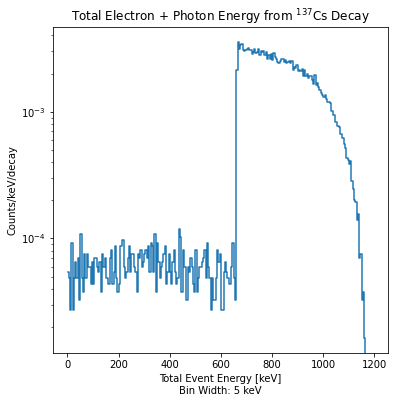

In [40]:
bins = np.arange(0, 1200, 5)
bin_width = bins[1] - bins[0]

handles = []
fig, axes = plt.subplots(figsize=(6,6))
centers, counts, errors = ta.hist(E_flat, bins=bins, scale_factor=1/num_decays)

if (do_save):
    with open(f"{data_dir}/cs137.npz", "wb") as npz_file:
        np.savez(npz_file, 
                 energy_keV=centers, 
                 counts_per_keV_per_decay=counts,
                 errors=errors)

plot, = axes.step(centers, counts, where="mid")
handles.append(plot)
axes.set_yscale("log")
axes.set_xlabel(f"Total Event Energy [keV]\n"
                f"Bin Width: {bin_width:.0f} keV")
axes.set_ylabel("Counts/keV/decay")
label = thesis.isotopes.ISOTOPES[isotope]["label"]
axes.set_title(f"Total Electron + Photon Energy from {label} Decay")

if (use_tex):
    fig.savefig(f"{figure_dir}/activation/energy_spectra/{isotope}_spectrum.pdf",
                dpi=FIG_DPI)
else:
    plt.show()